<a href="https://colab.research.google.com/github/ivyclare/PrivateAI/blob/master/COVID_PATE_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Possible Titles
#### Limited By Data

#### Detecting an Invisible Enemy With Invisible Data: PATE Analysis on COVID19

#### Detecting an Invisible Enemy With Invisible Data: Differential Privacy on COVID19

#### Privacy Preserving Covid-19 Diagnosis


http://www.cleverhans.io/privacy/2018/04/29/privacy-and-machine-learning.html
Our PATE approach at providing differential privacy to machine learning is based on a simple intuition: if two different classifiers, trained on two different datasets with no training examples in common, agree on how to classify a new input example, then that decision does not reveal information about any single training example. The decision could have been made with or without any single training example, because both the model trained with that example and the model trained without that example reached the same conclusion.

====================

In order to train MNIST in a differentially private manner, we need 2 main components; private datasets (teachers) and public unlabelled dataset (student). MNIST is divided into train and test data. Hence, we'll have to create the teacher and student datasets ourselves. 

We will follow the steps below, to create a privacy preserving MNIST deep learning model:

- Create the teacher and student datasets
    - The training data is divided into non-overlapping subsets
- 

### Data

For Training Teacher and Student and  Normal Training 
https://github.com/UCSD-AI4H/COVID-CT

For Testing these 2 methods
https://drive.google.com/uc?export=download&confirm=l5B4&id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
https://www.preprints.org/manuscript/202004.0086/v1(Find how to reference his here)

In [0]:
# # install syft package to use Private Aggregation of Teacher Ensembles (PATE)
!pip install syft


In [0]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
# import our libraries
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms,models
from torch.utils.data import Dataset, Subset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
import time, os
import math
from torch.autograd import Variable
from syft.frameworks.torch.dp import pate

%cd '/content/drive/My Drive/Colab Notebooks/OpenMined/'


/content/drive/My Drive/Colab Notebooks/OpenMined


### Step 1: Create Teacher and Student Datasets

In [0]:
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        label = int(self.img_list[idx][1])
#         sample = {'img': image,
#                   'label': int(self.img_list[idx][1])}
        return image, label



def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data


In [3]:
batchsize=16
path = './data/images'

data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# divided among teachers
trainset = CovidCTDataset(root_dir=f'{path}', 
                              txt_COVID='./data/labels/COVID/trainCT_COVID.txt',
                              #txt_COVID='/content/trainCT_COVID2.txt',
                              #txt_NonCOVID='/content/trainCT_NonCOVID2.txt',
                              txt_NonCOVID='./data/labels/NonCOVID/trainCT_NonCOVID.txt',
                              transform= data_transforms)
 
# used as student valid set    
validset = CovidCTDataset(root_dir=f'{path}',
                              txt_COVID='./data/labels/COVID/valCT_COVID.txt',
                              txt_NonCOVID='./data/labels/NonCOVID/valCT_NonCOVID.txt',
                              transform= data_transforms)

# used as student train set    
testset = CovidCTDataset(root_dir=f'{path}',
                              txt_COVID='./data/labels/COVID/testCT_COVID.txt',
                              txt_NonCOVID='./data/labels/NonCOVID/testCT_NonCOVID.txt',
                              transform= data_transforms)
print(trainset.__len__())
print(validset.__len__())
print(testset.__len__())
print("Number of Classes: ",len(trainset.classes))

425
118
203
Number of Classes:  2


In [0]:
# data_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)

# import matplotlib.pyplot as plt

# ## Method to display Image for Tensor
# def imshow(image, ax=None, title=None, normalize=True):
#     """Imshow for Tensor."""
#     if ax is None:
#         fig, ax = plt.subplots()
#     #print(type(image))
#     image = image.numpy().transpose((1, 2, 0))

#     if normalize:
#         mean = np.array([0.485, 0.456, 0.406])
#         std = np.array([0.229, 0.224, 0.225])
#         image = std * image + mean
#         image = np.clip(image, 0, 1)

#     ax.imshow(image)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.tick_params(axis='both', length=0)
#     ax.set_xticklabels('')
#     ax.set_yticklabels('')
#     return ax


# # Displaying Images and other info about the test set
# images, labels = next(iter(data_loader)) #trainloaders[2]
# # print(" Image Size",images.size())
# rand_idx = np.random.randint(len(images))
# # print(labels[rand_idx])

# fig, axes = plt.subplots(figsize=(16,5), ncols=5)
# for ii in range(5):
#     ax = axes[ii]
#     print(" Image Size",images[ii].size())
#     ax.set_title(labels[ii])
#     imshow(images[ii], ax=ax, normalize=True)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
len(trainset), len(testset)


(425, 203)

In [6]:
# TEACHERS
import random
#divide train set between teachers and create dataloaders for valid and trainsets
num_teachers = 5
valid_per = 0.1 #20% for validation
batch_size = 32


def teacher_dataloaders(transet=trainset, num_teachers=num_teachers, batch_size=batch_size, valid_per = 0.1):
  trainloaders = []
  validloaders = []
  teacher_data_len = len(trainset) // num_teachers

  # to create shuffled indices
  my_list = random.sample(range(1,len(trainset)), len(trainset)-1) #list(xrange(1,len(trainset)))
  random.shuffle(my_list)

  for i in range(num_teachers):
    # get particular subset of data
    
    indice = my_list[i*teacher_data_len: (i+1)*teacher_data_len]
    #indice = list(range(i*teacher_data_len, (i+1)*teacher_data_len))
    #print(indice)
    data_subset = Subset(trainset, indice)
    # split into train and validation set
    valid_size = int(len(data_subset) * valid_per)
    train_size = len(data_subset) - valid_size
    train_subset, valid_subset = torch.utils.data.random_split(data_subset, [train_size,valid_size])
    #print(len(train_subset))
    # print(len(valid_subset))

    #create data loaders
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
    validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

    #add dataloaders to list
    trainloaders.append(trainloader)
    validloaders.append(validloader)
  
  return trainloaders, validloaders

trainloaders, validloaders = teacher_dataloaders()
len(trainloaders[0]), len(validloaders)

(3, 5)

In [0]:
# doc(cnn_learner)

In [8]:
#  # STUDENT 
# split into train and validation set
valid_size = int(len(testset) * 0.2)
train_size = len(testset) - valid_size
student_train_subset, student_valid_subset = torch.utils.data.random_split(testset, [train_size,valid_size])
# print(len(train_subset))
# print(len(valid_subset))

#create data loaders
student_train_loader = DataLoader(student_train_subset, batch_size=batch_size, shuffle=False, num_workers=1)
student_valid_loader = DataLoader(student_valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(student_train_loader), len(student_valid_loader)

(6, 2)

## Step 2: Train Teachers

In [0]:
# define model
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(150528, 2056)
    self.fc2 = nn.Linear(2056, 1280)
    self.fc3 = nn.Linear(1280, 64)
    self.fc4 = nn.Linear(64, 2)
    #self.fc4 = nn.Linear(64, 1)
    self.dropout = nn.Dropout(p=0.4)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = self.fc4(x)
    #x = F.log_softmax(self.fc4(x), dim=1)
    #x = torch.sigmoid(x)

    return x

    #ValueError: Target and input must have the same number of elements. target nelement (60) != input nelement (3840)

In [0]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() # b, 3, 32, 32
        layer1 = torch.nn.Sequential() 
        layer1.add_module('conv1', torch.nn.Conv2d(3, 32, 3, 1, padding=1))
 
        #b, 32, 32, 32
        layer1.add_module('relu1', torch.nn.ReLU(True)) 
        layer1.add_module('pool1', torch.nn.MaxPool2d(2, 2)) # b, 32, 16, 16 //池化为16*16
        self.layer1 = layer1
        layer4 = torch.nn.Sequential()
        layer4.add_module('fc1', torch.nn.Linear(401408, 2))       
        self.layer4 = layer4
 
    def forward(self, x):
        conv1 = self.layer1(x)
        fc_input = conv1.view(conv1.size(0), -1)
        fc_out = self.layer4(fc_input)
        
        return fc_out

In [0]:
#  Pretained
# model = models.resnet34(pretrained=True)
# print(model.fc)

In [12]:
res_model = models.resnet34(pretrained=True)

# Freezing parameters
for param in res_model.parameters():
  param.require_grad = False

res_model.fc = torch.nn.Linear(res_model.fc.in_features, 2)
res_model.fc

Linear(in_features=512, out_features=2, bias=True)

In [0]:
def train(n_epochs, trainloader, validloader, model, optimizer, criterion, use_cuda, save_path= None, is_not_teacher=False):
    """returns trained model"""
    # # initialize tracker for minimum validation loss
    # if last_validation_loss is not None:
    #     valid_loss_min = last_validation_loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_correct = 0.0
        train_total = 0.0
        valid_correct =0.0
        valid_total = 0.0
        # train the model #
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # initialize weights to zero
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()    
            #train_loss += loss.item() * data.size(0)  
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            train_acc = 100. * train_correct / train_total
               
        # validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(validloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            #valid_loss += loss.item() * data.size(0)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            valid_total += data.size(0)
            valid_acc = 100. * valid_correct / valid_total
            
        # print training/validation statistics 
        print('Epoch: {} \n\tTrain Loss: {:.6f} \tTrain Acc: {:.6f} \n\tValid Loss: {:.6f} \tValid Acc: {:.6f}'.format(
            epoch,train_loss,train_acc,valid_loss,valid_acc ))
        
        ## save the model if validation loss has decreased
        if is_not_teacher:
          if valid_loss < valid_loss_min:
              #torch.save(model, save_path)
              torch.save(model.state_dict(), save_path)
              print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,
              valid_loss))
              valid_loss_min = valid_loss

    return model


In [0]:
model = res_model
#model = SimpleCNN()
#model = Net()
model.to(device)
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001)
#optimizer = optim.Adam(model.fc.parameters() , lr=0.001)

epochs = 50

In [15]:
teacher_models = []
i = 1
for trainloader, validloader in zip(trainloaders, validloaders):
  print(" Training Teacher {}".format(i))
  #teacher_model = train(trainloaders, validloaders, model, optimizer, criterion, epochs, device)
  #teacher_model = train(model, criterion, optimizer, trainloader, validloader)
  teacher_model = train(epochs, trainloader, validloader, model, optimizer, criterion, True)
  # teacher_model = cnn_learner(trainloader, resnet18, metrics=error_rate)
  # learn.fine_tune(10)
  teacher_models.append(teacher_model)
  i+=1
  print("======================================================")

 Training Teacher 1
Epoch: 1 
	Train Loss: 1.360199 	Train Acc: 46.753247 
	Valid Loss: 4.479617 	Valid Acc: 62.500000
Epoch: 2 
	Train Loss: 0.900999 	Train Acc: 74.025974 
	Valid Loss: 70.093437 	Valid Acc: 25.000000
Epoch: 3 
	Train Loss: 0.793108 	Train Acc: 72.727273 
	Valid Loss: 120.909546 	Valid Acc: 25.000000
Epoch: 4 
	Train Loss: 0.541289 	Train Acc: 76.623377 
	Valid Loss: 32.715752 	Valid Acc: 25.000000
Epoch: 5 
	Train Loss: 0.350553 	Train Acc: 84.415584 
	Valid Loss: 20.853598 	Valid Acc: 37.500000
Epoch: 6 
	Train Loss: 0.338961 	Train Acc: 85.714286 
	Valid Loss: 10.878061 	Valid Acc: 50.000000
Epoch: 7 
	Train Loss: 0.295166 	Train Acc: 83.116883 
	Valid Loss: 5.687944 	Valid Acc: 50.000000
Epoch: 8 
	Train Loss: 0.411553 	Train Acc: 81.818182 
	Valid Loss: 7.096727 	Valid Acc: 50.000000
Epoch: 9 
	Train Loss: 0.214055 	Train Acc: 90.909091 
	Valid Loss: 9.787548 	Valid Acc: 25.000000
Epoch: 10 
	Train Loss: 0.315013 	Train Acc: 85.714286 
	Valid Loss: 7.272943 	Vali

## Step 3: Get Private Student Labels 

In [16]:
# get private labels
def student_train_labels(teacher_models, dataloader):
  student_labels = []
  # get label for each teacher
  for model in teacher_models:
    student_label = []
    for images,_ in dataloader:
      with torch.no_grad():
        images = images.cuda()
        outputs = model(images)
        preds = torch.argmax(torch.exp(outputs), dim=1)
      student_label.append(preds.tolist())
    # add all teacher predictions to student_labels  
    student_label = sum(student_label, [])
    student_labels.append(student_label)
  return student_labels

predicted_labels = student_train_labels(teacher_models, student_train_loader)     
predicted_labels = np.array([np.array(p) for p in predicted_labels]).transpose(1, 0)
# We see here that we have 10 labels for each of image in our dataset
print(predicted_labels.shape)
print(predicted_labels[3])

(163, 5)
[0 0 0 0 0]


## Step 4: Add Laplacian Noise

In [0]:
# Get private labels with the most votes count and add noise them
def add_noise(predicted_labels, epsilon=0.1):
  noisy_labels = []
  for preds in predicted_labels:
    #print(preds.shape[0])
    # get labels with max votes
    label_counts = np.bincount(preds, minlength=2)
    
    # add laplacian noise to label
    epsilon = epsilon
    beta = 1/epsilon
    for i in range(len(label_counts)):
      label_counts[i] += np.random.laplace(0, beta, 1)
    
    # after adding noise we get labels with max counts
    new_label = np.argmax(label_counts)

    #output.write(new_label + "\n")

    noisy_labels.append(new_label)

  #return noisy_labels
  return np.array(noisy_labels)
  

In [18]:
# # Open File
# # resultFyle = open("output.csv",'w')

labels_with_noise = add_noise(predicted_labels, epsilon=0.6)
print(labels_with_noise)
print(labels_with_noise.shape)
print(type(labels_with_noise))

# #write to csv file
# import csv
# def write_csv(data):
#     with open('example.csv', 'a') as outfile:
#         writer = csv.writer(outfile)
#         writer.writerow(data)

# write_csv(labels_with_noise)

[0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
(163,)
<class 'numpy.ndarray'>


In [0]:

# #np.savetxt("filename.txt", labels_with_noise,fmt="%d")

# df = pd.read_csv('./example.csv',header=None)
# df.head()
# lst = df.iloc[0, :].tolist()

# arr = np.array(lst)
# # print(df['a'].to_list())
# print(type(arr))
# print(arr)
# arr.shape

## Step 5 Peform PATE Analysis

We'll explore different epsilon values and what they mean




In [20]:
# PATE analysis
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=predicted_labels.T, indices=labels_with_noise, noise_eps=0.1, delta=1e-5)
print('Data dependent epsilon:', data_dep_eps)
print('Data independent epsilon:', data_ind_eps)

Data dependent epsilon: 15.536462732485106
Data independent epsilon: 15.536462732485116


## Step 6: Train **Student**

In [21]:
# We have to create a new training dataloader for the student with the newly created 
# labels with noise. We have to replace the old labels with the new labels
def new_student_data_loader(dataloader, noisy_labels, batch_size=32):
  image_list = []
  for image,_ in dataloader:
    image_list.append(image)
    
  data = np.vstack(image_list)
  new_dataset = list(zip(data, noisy_labels))
  new_dataloader = DataLoader(new_dataset, batch_size, shuffle=False)

  return new_dataloader

labeled_student_trainloader = new_student_data_loader(student_train_loader, labels_with_noise)
len(labeled_student_trainloader),len(student_valid_loader)

(6, 2)

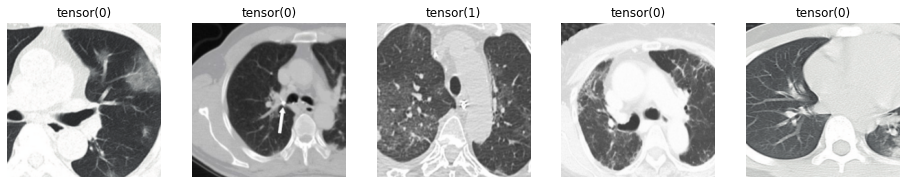

In [22]:
import matplotlib.pyplot as plt

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


# Displaying Images and other info about the test set
images, labels = next(iter(labeled_student_trainloader))
# print(" Image Size",images.size())
rand_idx = np.random.randint(len(images))
# print(labels[rand_idx])

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    # print(" Image Size",images[ii].size())
    ax.set_title(labels[ii])
    imshow(images[ii], ax=ax, normalize=True)

       

In [24]:
# Now we train the model
# We use the newly labeled trainloader for training and use the validloader data to evaluate the performance of our model

#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters() , lr=0.001)
# optimizer = optim.Adam(model.fc.parameters() , lr=0.001)

epochs = 50
#student_model = train(model, criterion, optimizer,labeled_student_trainloader,student_valid_loader)
# student_model = train(epochs, labeled_student_trainloader, student_valid_loader, model, optimizer, criterion, True)
student_model = train(epochs, labeled_student_trainloader, student_valid_loader, model, optimizer, criterion, True, save_path='./models/student.pth.tar', is_not_teacher=True)

# student_model = train(model, criterion, optimizer,student_trainloader, labeled_student_trainloader)



Epoch: 1 
	Train Loss: 0.159349 	Train Acc: 92.638037 
	Valid Loss: 1.172462 	Valid Acc: 50.000000
	Validation loss decreased (inf --> 1.172462).  Saving model ...
Epoch: 2 
	Train Loss: 0.125518 	Train Acc: 93.865031 
	Valid Loss: 3.057709 	Valid Acc: 47.500000
Epoch: 3 
	Train Loss: 0.112530 	Train Acc: 95.705521 
	Valid Loss: 2.811841 	Valid Acc: 47.500000
Epoch: 4 
	Train Loss: 0.074315 	Train Acc: 98.159509 
	Valid Loss: 4.257301 	Valid Acc: 45.000000
Epoch: 5 
	Train Loss: 0.063955 	Train Acc: 98.773006 
	Valid Loss: 3.203109 	Valid Acc: 50.000000
Epoch: 6 
	Train Loss: 0.053276 	Train Acc: 98.773006 
	Valid Loss: 4.385041 	Valid Acc: 52.500000
Epoch: 7 
	Train Loss: 0.029055 	Train Acc: 98.773006 
	Valid Loss: 2.543747 	Valid Acc: 55.000000
Epoch: 8 
	Train Loss: 0.015170 	Train Acc: 100.000000 
	Valid Loss: 2.422083 	Valid Acc: 42.500000
Epoch: 9 
	Train Loss: 0.008164 	Train Acc: 100.000000 
	Valid Loss: 2.358364 	Valid Acc: 45.000000
Epoch: 10 
	Train Loss: 0.004424 	Train Ac

# PATE
Shows us how much data has been leaked i.e the epsilon. 

Looks at the values produced from teachers and determines the level of agreement between them.



# TRAIN MNIST NORMALLY

In [25]:
# Normal DL Training
# normal_model = train(epochs, student_train_loader, student_valid_loader, model, optimizer, criterion, True)
normal_model = train(epochs, student_train_loader, student_valid_loader, model, optimizer, criterion, True, save_path='./models/normal.pth.tar', is_not_teacher=True)


Epoch: 1 
	Train Loss: 2.406557 	Train Acc: 56.441718 
	Valid Loss: 71.345871 	Valid Acc: 40.000000
	Validation loss decreased (inf --> 71.345871).  Saving model ...
Epoch: 2 
	Train Loss: 0.789787 	Train Acc: 65.030675 
	Valid Loss: 39.949337 	Valid Acc: 57.500000
	Validation loss decreased (71.345871 --> 39.949337).  Saving model ...
Epoch: 3 
	Train Loss: 0.595972 	Train Acc: 68.711656 
	Valid Loss: 2.211688 	Valid Acc: 45.000000
	Validation loss decreased (39.949337 --> 2.211688).  Saving model ...
Epoch: 4 
	Train Loss: 0.528409 	Train Acc: 78.527607 
	Valid Loss: 160.939697 	Valid Acc: 40.000000
Epoch: 5 
	Train Loss: 0.411557 	Train Acc: 80.368098 
	Valid Loss: 92.121185 	Valid Acc: 40.000000
Epoch: 6 
	Train Loss: 0.382044 	Train Acc: 82.208589 
	Valid Loss: 14.560678 	Valid Acc: 42.500000
Epoch: 7 
	Train Loss: 0.434697 	Train Acc: 78.527607 
	Valid Loss: 4.843095 	Valid Acc: 47.500000
Epoch: 8 
	Train Loss: 0.311494 	Train Acc: 87.116564 
	Valid Loss: 1.234060 	Valid Acc: 52.

### Comparing Normal DL Model and Privacy Preserving Model

In [26]:
# Test Dataset
batch_size=16
print(batch_size)
len(validset)
dataloader = DataLoader(validset, batch_size=batchsize, shuffle=False)


16


In [32]:
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def test(dataloader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(dataloader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
       
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('\tTest Loss: {:.6f}'.format(test_loss))
    print('\tTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
print("Student Model")     
test(dataloader, student_model, criterion, True)

print("\n=======================\nNormal Model")
test(dataloader, normal_model, criterion, True)

Student Model
	Test Loss: 0.890114
	Test Accuracy: 76% (90/118)

Normal Model
	Test Loss: 0.745848
	Test Accuracy: 77% (92/118)
